In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['stage_2_test_images', 'stage_2_sample_submission.csv', 'stage_2_detailed_class_info.csv', 'stage_2_train_images', 'stage_2_train_labels.csv', 'GCP Credits Request Link - RSNA.txt']


In [2]:
# take a look at the labels CSV file first
df = pd.read_csv('../input/stage_2_train_labels.csv')
print(df.iloc[0])

patientId    0004cfab-14fd-4e49-80ba-63a80b6bddd6
x                                             NaN
y                                             NaN
width                                         NaN
height                                        NaN
Target                                          0
Name: 0, dtype: object


The above cell is an example of what the CSV file contains. Each row corresponds to a unique `patientId`, a `Target` which indicates whether or not that observation had pneumonia, and the `x` & `y` correspond to the coordinates of the upper-left hand corner of the bounding box. `width` and `height` represent the respective bounding boxes dimensions

Important to note that the `Target` is 0, which means that this instance does _not_ have pneumonia. Below is an example of a case that _does_ have pneumonia (i.e. `Target` is equal to 1)

In [3]:
print(df.iloc[4])

patientId    00436515-870c-4b36-a041-de91049b9ab4
x                                             264
y                                             152
width                                         213
height                                        379
Target                                          1
Name: 4, dtype: object


# Overview of DICOM

Medical images are stored in a special format known as DICOM files `*.dcm`. 

Contain a combination of metadata and the underlying raw image arrays for pixel data. `pydicom` module can be used to access and manipulate these type of files.

To use the `pydicom` library:

- first, find the DICOM file for a given `patientId`
    - can do this by looking for the matching file in the `stage_2_train_images/` folder
- then use `pydicom.read_file()` method to load the data

In [4]:
import pydicom, glob, pylab

In [5]:
patientId = df['patientId'][0]
dcm_file = '../input/stage_2_train_images/%s.dcm' % patientId
dcm_data = pydicom.read_file(dcm_file)

dcm_data

(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0016) SOP Class UID                       UI: Secondary Capture Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.2.276.0.7230010.3.1.4.8323329.28530.1517874485.775526
(0008, 0020) Study Date                          DA: '19010101'
(0008, 0030) Study Time                          TM: '000000.00'
(0008, 0050) Accession Number                    SH: ''
(0008, 0060) Modality                            CS: 'CR'
(0008, 0064) Conversion Type                     CS: 'WSD'
(0008, 0090) Referring Physician's Name          PN: ''
(0008, 103e) Series Description                  LO: 'view: PA'
(0010, 0010) Patient's Name                      PN: '0004cfab-14fd-4e49-80ba-63a80b6bddd6'
(0010, 0020) Patient ID                          LO: '0004cfab-14fd-4e49-80ba-63a80b6bddd6'
(0010, 0030) Patient's Birth Date                DA: ''
(0010, 0040) Patient's Sex                       CS: 'F'
(0010, 1010) Patient'

We'll need to access the pixel data.

In [6]:
im = dcm_data.pixel_array
print(type(im))
print(im.dtype)
print(im.shape)

<class 'numpy.ndarray'>
uint8
(1024, 1024)


# See an Example

Use `pylab.imshow()` method to take a look at DICOM image.

(-0.5, 1023.5, 1023.5, -0.5)

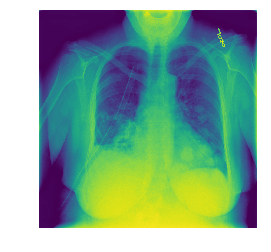

In [7]:
pylab.imshow(im)
pylab.axis('off')

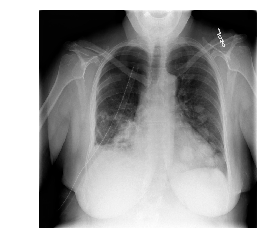

In [8]:
pylab.imshow(im, cmap=pylab.cm.gist_gray)
pylab.axis('off');

# Exploring the Data and Labels

We need to convert current CSV file dataframe into a dictionary with unique entries for each patient. Create a function that reads in a CSV file (i.e. pandas dataframe) and parses the data into a nested dictionary.

In [9]:
def parse_data(df):
    # use lambda to extract coords in list i.e. the box [y, x, height, width]
    extract_box = lambda row: [row['y'], row['x'], row['height'], row['width']]
    # create empty dictionary to store everything
    parsed = {}
    # use for loop to iterate through each patient entry
    for n, row in df.iterrows():
        # initialize patient entry into parsed
        pid = row['patientId']
        if pid not in parsed:
            parsed[pid] = {
                'dicom': '../input/stage_2_train_images/%s.dcm' % pid, #input metadata
                'label': row['Target'], # imput whether or not patient had pneumonia
                'boxes': [] # initiate list to potentially store box coordinates 
            }
            
        # add box if opacity is present
        if parsed[pid]['label'] == 1:
            parsed[pid]['boxes'].append(extract_box(row))
            
    return parsed

Use `parse_data` method on `df` to generate dictionary with each patient having a unique entry

In [10]:
# call parse_data on df
parsed = parse_data(df)

Patient `0004cfab-14fd-4e49-80ba-63a80b6bddd6` did not have pneumonia. To ensure we parsed the data correctly, lets check this entry in `parsed`. It should return a `label` of 0.

In [11]:
print(parsed['0004cfab-14fd-4e49-80ba-63a80b6bddd6'])

{'dicom': '../input/stage_2_train_images/0004cfab-14fd-4e49-80ba-63a80b6bddd6.dcm', 'label': 0, 'boxes': []}


Patient `00436515-870c-4b36-a041-de91049b9ab4` __did__ have pneumonia. To double check the data, lets see if this entry in `parsed` returns a `label` of 1.

In [12]:
print(parsed['00436515-870c-4b36-a041-de91049b9ab4'])

{'dicom': '../input/stage_2_train_images/00436515-870c-4b36-a041-de91049b9ab4.dcm', 'label': 1, 'boxes': [[152.0, 264.0, 379.0, 213.0], [152.0, 562.0, 453.0, 256.0]]}


# Visualize Boxes

We're going to create some methods that will helps us to visualize the bounding boxes and overlay them on the original grayscale DICOM files

In [13]:
# create function that draws patients bounding box(es) if present
def draw(data):
    # open DICOM file
    d = pydicom.read_file(data['dicom'])
    im = d.pixel_array
    
    # convert single-channel greyscale to 3-channel RGB
    im = np.stack([im] * 3, axis = 2)
    
    # add boxes with random color if present
    for box in data['boxes']:
        rgb = np.floor(np.random.rand(3) * 256).astype('int')
        im = overlay_box(im=im, box=box, rgb=rgb, stroke=6)
    
    pylab.imshow(im, cmap=pylab.cm.gist_gray)
    pylab.axis('off')


# create overlay_box function that will allow us to overlay the box on the greyscale images
def overlay_box(im, box, rgb, stroke=1):
    # convert coordinates to integers
    box = [int(b) for b in box]
    
    # extract coordinates
    y1, x1, height, width = box
    y2 = y1 + height
    x2 = x1 + width
    
    im[y1:y1 + stroke, x1:x2] = rgb
    im[y2:y2 + stroke, x1:x2] = rgb
    im[y1:y2, x1:x1 + stroke] = rgb
    im[y1:y2, x2:x2 + stroke] = rgb
    
    return im

Patient `00436515-870c-4b36-a041-de91049b9ab4` has pneumonia so let's see what it looks like with the boxes. 

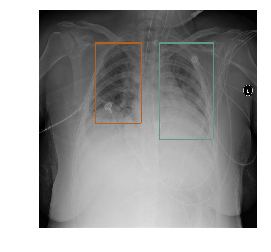

In [14]:
draw(parsed['00436515-870c-4b36-a041-de91049b9ab4'])

# Exploring Detailed Labels

This is not a simple binary classification as those without pneumonia are further categorized into __normal__ or __no lung opacity / not normal__. This third class indicates that while pneumonia was determined to not be present, there was still some type of abnormality present. 

To begin let's take a look at the detailed label information for the patient we looked at earlier that did not have pneumonia. 

In [15]:
df_detailed = pd.read_csv('../input/stage_2_detailed_class_info.csv')

print(df_detailed.iloc[0])

patientId    0004cfab-14fd-4e49-80ba-63a80b6bddd6
class                No Lung Opacity / Not Normal
Name: 0, dtype: object


While this patient didn't have pneumonia, there appeared to be something abnormal in their image.

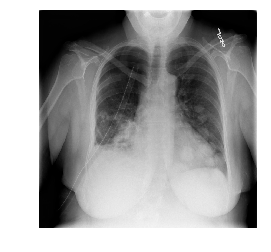

In [16]:
patient_zero = df_detailed['patientId'][0]
draw(parsed[patient_zero])

# Label Summary

Let's take a closer look at the distribution of the labels in the dataset. First, we need to parse the detailed label information. 

In [17]:
summary = {}
for n, row in df_detailed.iterrows():
    if row['class'] not in summary:
        summary[row['class']] = 0
    summary[row['class']] += 1

In [18]:
print(summary)

{'No Lung Opacity / Not Normal': 11821, 'Normal': 8851, 'Lung Opacity': 9555}


Unlike many medical imaging datasets, where the prevelance of disease tends to be disporportionately low, this data set appears to have a pretty significant number with pneumonia. 